In [200]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random as random
from sklearn.cluster import k_means
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from sklearn import cross_validation

#Fit the code to the screen
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
my_path = !pwd
with open(my_path[0]+'/features/user_features_advanced.pik', 'rb') as handle:
    user_features = pickle.load(handle)
with open(my_path[0]+'/features/movie_features.pik', 'rb') as handle:
    movies_features = pickle.load(handle)

In [18]:
user_features_for_cluser = user_features.copy(deep=True)
#UserId is not an informative feature
del user_features_for_cluser["userId"]
#Binarizing the gender feature (M=1, F=0)
user_features_for_cluser["gender"] = user_features_for_cluser['gender'].apply(lambda x: 1 if (x=="M") else 0)

In [5]:
#Reading the ratings data
ratings_filename = "/ml-1m/ratings.dat"
dfratings = pd.read_csv(my_path[0]+ratings_filename, index_col=None, sep='::', header=None)
dfratings.columns = ["userId", "movieId", "rating", "timestamp"]

/home/anat/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


## Users clustering

In [29]:
#Create 1000 clusters using k-means and addrs as feature
users_100_kmeans = k_means(user_features_for_cluser, 100, n_jobs=-1)
with open(my_path[0]+'/clustering/users_100_kmeans.pik', 'wb') as handle:
    pickle.dump(users_100_kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
users_50_kmeans = k_means(user_features_for_cluser, 50, n_jobs=-1)
with open(my_path[0]+'/clustering/users_100_kmeans.pik', 'wb') as handle:
    pickle.dump(users_50_kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
#For example, find all users in the cluster of user 1:
user_cluster = users_50_kmeans[1][1]
cluster_indices = (np.where(users_50_kmeans[1]==user_cluster))[0]

In [127]:
N = dfratings.shep[0]

In [208]:
predicted_movieIds = (user_ratings["movieId"])[user_ratings_test_indices]
real_ratings = (user_ratings["rating"])[user_ratings_test_indices]

### Predict using the user's cluster ratings

In [235]:
#Order the movie ids according to their ratings, from highest to lowest rating
def order_by_rating(movie_ids, ratings):
    movies_ar = np.array(movie_ids)
    ratings_ar = np.array(ratings)
    inds = ratings_ar.argsort()
    sorted_movie_ids = movies_ar[inds]
    de_sorted_movie_ids = np.fliplr([sorted_movie_ids])[0]
    
    return de_sorted_movie_ids

In [154]:
#Retrurn the average rating of movie_id by the group users_id
def avg_movie_rating(users_ids, movie_id):
    ratings_sum = 0
    ratings_num = 0
    for userId in users_ids:
        user_ratings = dfratings[dfratings["userId"] == userId]
        movie_rating = user_ratings[user_ratings["movieId"] == movie_id]["rating"]
        if (len(movie_rating) > 0):
            score = movie_rating.item()
            ratings_sum += score
            ratings_num += 1,
    
    #Calculate the average
    if (ratings_num > 0):
        ratings_avg = ratings_sum/float(ratings_num)
    else:
        ratings_avg = 0
    return ratings_avg

In [301]:
tested_userIds = [457, 2768, 1980, 402, 4126, 3418, 1112, 3119, 1737, 1322]

In [291]:
#For each user, predict for random 10% of its rated movies
random_seed = 42
ndcg_all_users_k5 = []
ndcg_all_users_k10 = []
ndcg_all_users_k15 = []
ndcg_all_users_k20 = []
for tested_userId in tested_userIds:
    #Get the ratings for that user
    user_ratings = dfratings[dfratings["userId"] == tested_userId]
    user_ratings.reset_index(inplace=True)
    
    #Choose randomly 10% of the ratings
    user_ratings_shuffle_indices = cross_validation.ShuffleSplit(len(user_ratings), n_iter=10, test_size=0.1, random_state=random_seed)
    
    #Save the ndcg for each 10% reviews
    ndcg_user_k5 = []
    ndcg_user_k10 = []
    ndcg_user_k15 = []
    ndcg_user_k20 = []
    
    #Predict rating for the chosen 10% ratings
    for dummy_train_indices, user_ratings_test_indices in user_ratings_shuffle_indices:
       
        #Get the 10% movie ids
        predicted_movieIds = (user_ratings["movieId"])[user_ratings_test_indices]
        real_ratings = (user_ratings["rating"])[user_ratings_test_indices]
        #real_order = order_by_rating(predicted_movieIds, real_ratings)
        
        #predict rating for (userId, movieId) using cluster average and user effect
        pred_avg_effect = []
        for movieId in predicted_movieIds:
            user_cluster = users_50_kmeans[1][userId-1] #the index in cluster is 1 decrement from the id
            cluster_indices = ((np.where(users_50_kmeans[1]==user_cluster))[0]).tolist()
            cluster_user_ids = [i+1 for i in cluster_indices]
            cluster_user_ids.remove(userId)
            
            #Get the average rating for the other cluster members
            cluster_avg_rating = avg_movie_rating(cluster_user_ids, movieId)
            
            #If no one in the cluster have seen the movie
            if (cluster_avg_rating == 0):
                cluster_avg_rating = movies_features[movies_features["movieId"] == movieId]["avg_rate"].item()
            
            #Adding the user effect to the average
            user_effect = user_features[user_features["userId"] == userId]["avg_score_diff"].item()
            pred_rating = cluster_avg_rating + user_effect
            if (pred_rating > 5):
                pred_rating = 5
            if (pred_rating < 0):
                pred_rating = 0
                
            #Adding to ratings_results
            pred_avg_effect.append(pred_rating)
            
        #NDCG calculations
        if (len(real_ratings) >= 5):
            avg_effect_ndcg_k5 = ndcg_score(real_ratings, pred_avg_effect, k=5)
            ndcg_user_k5.append(avg_effect_ndcg_k5)
        else:
            ndcg_user_k5.append(None)
        
        if (len(real_ratings) >= 10):
            avg_effect_ndcg_k10 = ndcg_score(real_ratings, pred_avg_effect, k=10)
            ndcg_user_k10.append(avg_effect_ndcg_k10)
        else:
            ndcg_user_k10.append(None)
        
        if (len(real_ratings) >= 15):
            avg_effect_ndcg_k15 = ndcg_score(real_ratings, pred_avg_effect, k=15)
            ndcg_user_k15.append(avg_effect_ndcg_k15)
        else:
            ndcg_user_k15.append(None)
            
        if (len(real_ratings) >= 20):
            avg_effect_ndcg_k20 = ndcg_score(real_ratings, pred_avg_effect, k=20)
            ndcg_user_k20.append(avg_effect_ndcg_k20)
        else:
            ndcg_user_k20.append(None)
            
    
    #Add all the user ndcg scores to the big arrays
    ndcg_all_users_k5.append(ndcg_user_k5)
    ndcg_all_users_k10.append(ndcg_user_k10)
    ndcg_all_users_k15.append(ndcg_user_k15)
    ndcg_all_users_k20.append(ndcg_user_k20)
    
    print "Finished user: "+str(tested_userId)
    
        #Ordering 10% movies using the predicted ranking
        #avg_effect_order = order_by_rating(predicted_movieIds, pred_avg_effect)
        #size = len(predicted_movieIds)
        #avg_dcg = dcg_score(real_order, avg_order k=size)
        #avg_effect_dcg = dcg_score(real_order, avg_effect_order k=size)

Finished user: 457
Finished user: 2768
Finished user: 1980
Finished user: 402
Finished user: 4126
Finished user: 3418
Finished user: 1112
Finished user: 3119
Finished user: 1737
Finished user: 1322


In [297]:
with open(my_path[0]+'/clustering/ndcg_all_users_k5.pik', 'wb') as handle:
    pickle.dump(ndcg_all_users_k5, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(my_path[0]+'/clustering/ndcg_all_users_k10.pik', 'wb') as handle:
    pickle.dump(ndcg_all_users_k10, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(my_path[0]+'/clustering/ndcg_all_users_k15.pik', 'wb') as handle:
    pickle.dump(ndcg_all_users_k15, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(my_path[0]+'/clustering/ndcg_all_users_k20.pik', 'wb') as handle:
    pickle.dump(ndcg_all_users_k20, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [318]:
ndcg_df_k5 = pd.DataFrame([ndcg_all_users_k5[i] for i in range(10)])
ndcg_df_k5 = ndcg_df_k5.transpose()
ndcg_df_k5.columns = tested_userIds

In [319]:
ndcg_df_k5

,457,2768,1980,402,4126,3418,1112,3119,1737,1322
0,0.825251,0.932895,0.757231,0.693572,0.321317,0.824950,0.924610,0.895036,0.504039,0.912475
1,0.954437,0.954437,0.711864,0.746447,0.416514,0.484232,0.932281,0.951005,0.624339,0.787977
2,0.856447,0.856948,0.714505,0.637485,0.346673,0.703045,1.000000,0.645251,0.621226,0.646786
3,0.897857,1.000000,0.688945,0.709696,0.583329,0.712823,1.000000,0.584912,0.314888,0.819196
4,0.882815,0.970210,0.539455,0.682033,0.336091,0.504558,0.757231,0.933986,0.757231,0.889555
5,0.856447,0.857455,0.737424,0.658921,0.270416,0.607716,1.000000,0.618681,0.714505,0.691744
6,0.658921,0.856948,0.496367,0.643710,0.252550,0.727356,1.000000,0.840607,0.440108,0.824950
7,0.837085,0.886237,0.679089,0.564682,0.571758,0.767134,1.000000,0.955991,0.691224,0.725603
8,0.837085,1.000000,0.639115,0.718351,0.363005,0.844756,0.837085,0.419792,0.515498,0.714505
9,0.769366,0.868764,1.000000,0.559261,0.351027,0.450727,0.800993,0.543600,0.429168,0.868712


In [372]:
#Calculating the average for each user
avg_k5 = [np.average(ndcg_all_users_k5[i]) for i in range(10)]
avg_k10 = []
avg_k15 = []
avg_k20 = []
for i in range(10):
    if (ndcg_all_users_k10[i][0] == None):
        avg_k10.append(0)
    else:
        avg_k10.append(np.average(ndcg_all_users_k10[i]))
        
    if (ndcg_all_users_k15[i][0] == None):
        avg_k15.append(0)
    else:
        avg_k15.append(np.average(ndcg_all_users_k15[i]))
        
    if (ndcg_all_users_k20[i][0] == None):
        avg_k20.append(0)
    else:
        avg_k20.append(np.average(ndcg_all_users_k20[i]))

In [373]:
#Calculating the std for each user
std_k5 = [np.std(ndcg_all_users_k5[i]) for i in range(10)]
std_k10 = []
std_k15 = []
std_k20 = []
for i in range(10):
    if (ndcg_all_users_k10[i][0] == None):
        std_k10.append(0)
    else:
        std_k10.append(np.std(ndcg_all_users_k10[i]))
        
    if (ndcg_all_users_k15[i][0] == None):
        std_k15.append(0)
    else:
        std_k15.append(np.std(ndcg_all_users_k15[i]))
        
    if (ndcg_all_users_k20[i][0] == None):
        std_k20.append(0)
    else:
        std_k20.append(np.std(ndcg_all_users_k20[i]))

In [364]:
#A dataframe for all the average scores
ndcg_avg_df = pd.DataFrame([avg_k5, avg_k10, avg_k15, avg_k20])
ndcg_avg_df.columns = ["u457", "u2768", "u1980", "u402", "u4126", "u3418", "u1112", "u3119", "1737", "u1322"]
ndcg_avg_df.index = [5, 10, 15, 20]

In [365]:
ndcg_avg_df

,u457,u2768,u1980,u402,u4126,u3418,u1112,u3119,1737,u1322
5,0.837571,0.91839,0.696400,0.661416,0.381268,0.662730,0.925220,0.738886,0.561223,0.788150
10,0.894140,NaN,0.752077,0.777461,0.485098,0.668665,0.854335,NaN,0.572676,0.749947
15,0.916409,NaN,0.743356,0.802298,0.544368,0.780499,0.820288,NaN,0.639588,0.746589
20,0.924941,NaN,0.731621,0.844228,0.608833,0.850528,0.843429,NaN,0.683317,0.790532


In [345]:
#Some users statistics
ratings_num = []
ratings_avg = []
ratings_std = []
for userId in tested_userIds:
    user_profile = user_features[user_features["userId"] == userId]
    ratings_num.append(user_profile["rate_num"].item())
    ratings_avg.append(user_profile["rate_avg"].item())
    ratings_std.append(user_profile["rate_std"].item())

In [347]:
#A dataframe with all the stats
stats_df = pd.DataFrame([ratings_num, ratings_avg, ratings_std])
stats_df.columns = tested_userIds
stats_df

,457,2768,1980,402,4126,3418,1112,3119,1737,1322
0,237.000000,80.000000,1260.000000,284.000000,358.000000,211.000000,679.000000,90.000000,775.000000,384.000000
1,3.713080,4.037500,3.482540,3.591549,3.513966,3.791469,3.441826,3.377778,3.410323,4.117188
2,0.905887,0.797555,1.026094,0.873353,0.902248,1.221499,1.240844,1.269976,0.984733,0.803194


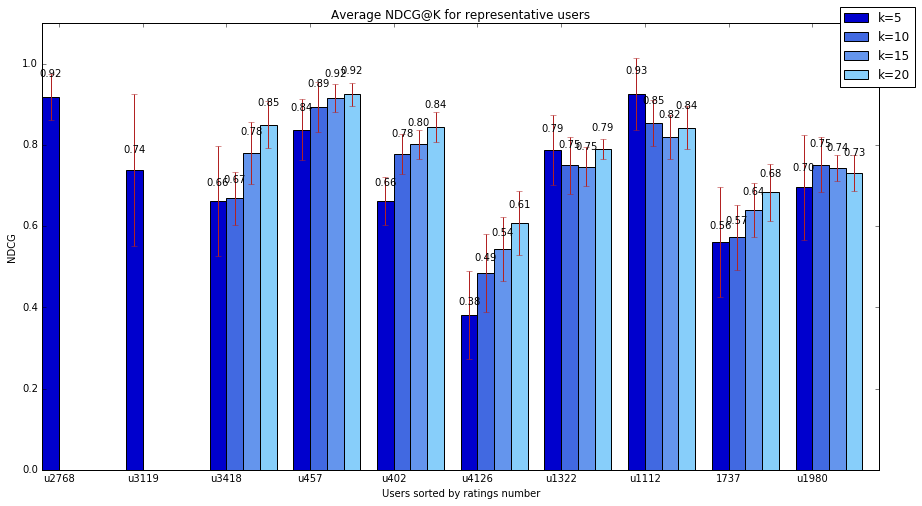

In [480]:
sort_by_stat(ratings_num, "ratings number")
plt.savefig(my_path[0]+'/clustering/ndcg_ratings_num.pdf')

In [477]:
def sort_by_stat(stat_list, x_axis_text):
    #Sort everything by stat list
    stat_inds = (np.array(stat_list)).argsort()

    #Averages
    tmp_avg_k5 = np.array(avg_k5)[stat_inds]
    sorted_avg_k5 = tmp_avg_k5.tolist()
    tmp_avg_k10 = np.array(avg_k10)[stat_inds]
    sorted_avg_k10 = tmp_avg_k10.tolist()
    tmp_avg_k15 = np.array(avg_k15)[stat_inds]
    sorted_avg_k15 = tmp_avg_k15.tolist()
    tmp_avg_k20 = np.array(avg_k20)[stat_inds]
    sorted_avg_k20 = tmp_avg_k20.tolist()

    #stds
    tmp_std_k5 = np.array(std_k5)[stat_inds]
    sorted_std_k5 = tmp_std_k5.tolist()
    tmp_std_k10 = np.array(std_k10)[stat_inds]
    sorted_std_k10 = tmp_std_k10.tolist()
    tmp_std_k15 = np.array(std_k15)[stat_inds]
    sorted_std_k15 = tmp_std_k15.tolist()
    tmp_std_k20 = np.array(std_k20)[stat_inds]
    sorted_std_k20 = tmp_std_k20.tolist()
    
    #Sort titles
    titles = ["u457", "u2768", "u1980", "u402", "u4126", "u3418", "u1112", "u3119", "1737", "u1322"]
    tmp_titles = np.array(titles)[stat_inds]
    sorted_titles = tmp_titles.tolist()
    
    #Make plot
    ndcg_plt(sorted_avg_k5, sorted_avg_k10, sorted_avg_k15, sorted_avg_k20, sorted_std_k5, sorted_std_k10, sorted_std_k15, sorted_std_k20, sorted_titles, x_axis_text)

In [461]:
avg_k5

[0.83757116223413652,
 0.91838955831288405,
 0.69639959689723507,
 0.66141586289149179,
 0.38126784480660431,
 0.66272975375606546,
 0.92522000546642202,
 0.73888598060719624,
 0.56122277823250366,
 0.78815040367561662]

In [462]:
sort_by_ratings_num.tolist()

[0.918389558312884,
 0.7388859806071962,
 0.6627297537560655,
 0.8375711622341365,
 0.6614158628914918,
 0.3812678448066043,
 0.7881504036756166,
 0.925220005466422,
 0.5612227782325037,
 0.6963995968972351]

In [ ]:
people = numpy.array(people)
ages = numpy.array(ages)
inds = ages.argsort()
sortedPeople = people[inds]

In [476]:
def ndcg_plt(avg_k5, avg_k10, avg_k15, avg_k20, std_k5, std_k10, std_k15, std_k20, xlables, x_axis_text):
    N = 10

    ind = np.arange(N)  # the x locations for the groups
    width = 0.20       # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 8))
    rects1 = ax.bar(ind , avg_k5, width, color='mediumblue', yerr=std_k5, ecolor='firebrick')
    rects2 = ax.bar(ind + width, avg_k10, width, color='royalblue', yerr=std_k10, ecolor='firebrick')
    rects3 = ax.bar(ind + (2 * width), avg_k15, width, color='cornflowerblue', yerr=std_k15, ecolor='firebrick')
    rects4 = ax.bar(ind + (3 * width), avg_k20, width, color='lightskyblue', yerr=std_k20, ecolor='firebrick')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('NDCG')
    ax.set_xlabel('Users sorted by '+x_axis_text)
    ax.set_title('Average NDCG@K for representative users')
    ax.set_xticks(ind + width)
    #ax.set_xticklabels(("u457", "u2768", "u1980", "u402", "u4126", "u3418", "u1112", "u3119", "1737", "u1322"))
    ax.set_xticklabels(xlables)
    ax.set_ylim([0,1.1])

    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('k=5', 'k=10', 'k=15', 'k=20'), bbox_to_anchor=(1.05, 1.05))


    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            if (height > 0):
                ax.text(rect.get_x()+ rect.get_width()/2. , 1.05*height, '%.2f' % height, ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    plt.show()

In [344]:
user_features[user_features["userId"] == 1]

,userId,gender,age,occupation,Mystery,Sci-Fi,Crime,Drama,Animation,IMAX,...,Musical,Fantasy,Adventure,Children,Thriller,Western,rate_num,rate_avg,rate_std,avg_score_diff
0,1,F,1,10,0,13,8,93,74,0,...,60,12,20,85,11,0,53,4.188679,0.674512,0.266306


In [192]:
print r2_score(label, pred_avg_effect), 
print mean_squared_error(label, pred_avg_effect)

0.219286245711 1.03202863465


pred_avg_effect: RMSE- 1.01588810144
pred_avg_effect: R - 0.495525578846
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     324.8
Date:                Tue, 03 May 2016   Prob (F-statistic):           4.41e-63
Time:                        21:12:03   Log-Likelihood:                -995.08
No. Observations:                1000   AIC:                             1994.
Df Residuals:                     998   BIC:                             2004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

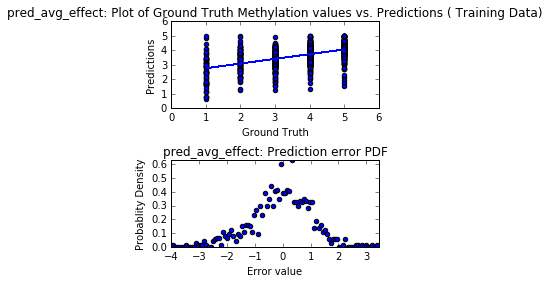

In [191]:
name = "pred_avg_effect"
y_predict = label
predictions = pred_avg_effect

# fit a linear regression line
xs = y_predict
ys = predictions
results = sm.OLS(ys,sm.add_constant(xs)).fit()
# compute root mean squared error
mean_sq_error = np.mean((y_predict-predictions)**2)
print name + ": RMSE- " + str(np.sqrt(mean_sq_error))

#Compute R
r = np.corrcoef(y_predict,predictions)[0][1]
print name + ": R - "+str(r)

print results.summary()

#plot
plt.subplot(2, 1, 1)
plt.scatter(xs,ys)
plt.plot(xs, xs*results.params[1] + results.params[0],rasterized=True)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title(name + ': Plot of Ground Truth Methylation values vs. Predictions ( Training Data)')
plt.subplot(2, 1, 2)
hist,bin_edges = np.histogram((y_predict-predictions),bins=100,density=True)
plt.title(name + ': Prediction error PDF')
plt.xlabel('Error value')
plt.ylabel('Probablity Density')    
plt.scatter(bin_edges[:-1],hist)
plt.xlim(min(bin_edges), max(bin_edges))
plt.ylim(min(hist), max(hist))
plt.tight_layout()
plt.savefig(my_path[0]+"/"+name+"_prediction_plot.png",dpi=200,bbox_inches='tight')
plt.show()

In [194]:
dcg_score(label, pred_avg_effect)

122.92686622450273

In [193]:
# (C) Mathieu Blondel, November 2013
# License: BSD 3 clause

import numpy as np


def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    y_score : array-like, shape = [n_samples]
        Predicted scores.

    k : int
        Rank.

    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)

    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)


def average_precision_score(y_true, y_score, k=10):
    """Average precision at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    y_score : array-like, shape = [n_samples]
        Predicted scores.

    k : int
        Rank.

    Returns
    -------
    average precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)

    order = np.argsort(y_score)[::-1][:min(n_pos, k)]
    y_true = np.asarray(y_true)[order]

    score = 0
    for i in xrange(len(y_true)):
        if y_true[i] == pos_label:
            # Compute precision up to document i
            # i.e, percentage of relevant documents up to document i.
            prec = 0
            for j in xrange(0, i + 1):
                if y_true[j] == pos_label:
                    prec += 1.0
            prec /= (i + 1.0)
            score += prec

    if n_pos == 0:
        return 0

    return score / n_pos


def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    y_score : array-like, shape = [n_samples]
        Predicted scores.

    k : int
        Rank.

    gains : str
        Whether gains should be "exponential" (default) or "linear".

    Returns
    -------
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    y_score : array-like, shape = [n_samples]
        Predicted scores.

    k : int
        Rank.

    gains : str
        Whether gains should be "exponential" (default) or "linear".

    Returns
    -------
    NDCG @k : float
    """
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best


# Alternative API.

def dcg_from_ranking(y_true, ranking):
    """Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    ranking : array-like, shape = [k]
        Document indices, i.e.,
            ranking[0] is the index of top-ranked document,
            ranking[1] is the index of second-ranked document,
            ...

    k : int
        Rank.

    Returns
    -------
    DCG @k : float
    """
    y_true = np.asarray(y_true)
    ranking = np.asarray(ranking)
    rel = y_true[ranking]
    gains = 2 ** rel - 1
    discounts = np.log2(np.arange(len(ranking)) + 2)
    return np.sum(gains / discounts)


def ndcg_from_ranking(y_true, ranking):
    """Normalized discounted cumulative gain (NDCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).

    ranking : array-like, shape = [k]
        Document indices, i.e.,
            ranking[0] is the index of top-ranked document,
            ranking[1] is the index of second-ranked document,
            ...

    k : int
        Rank.

    Returns
    -------
    NDCG @k : float
    """
    k = len(ranking)
    best_ranking = np.argsort(y_true)[::-1]
    best = dcg_from_ranking(y_true, best_ranking[:k])
    return dcg_from_ranking(y_true, ranking) / best


if __name__ == '__main__':

    # Check that some rankings are better than others
    assert dcg_score([5, 3, 2], [2, 1, 0]) > dcg_score([4, 3, 2], [2, 1, 0])
    assert dcg_score([4, 3, 2], [2, 1, 0]) > dcg_score([1, 3, 2], [2, 1, 0])

    assert dcg_score([5, 3, 2], [2, 1, 0], k=2) > dcg_score([4, 3, 2], [2, 1, 0], k=2)
    assert dcg_score([4, 3, 2], [2, 1, 0], k=2) > dcg_score([1, 3, 2], [2, 1, 0], k=2)

    # Perfect rankings
    assert ndcg_score([5, 3, 2], [2, 1, 0]) == 1.0
    assert ndcg_score([2, 3, 5], [0, 1, 2]) == 1.0
    assert ndcg_from_ranking([5, 3, 2], [0, 1, 2]) == 1.0

    assert ndcg_score([5, 3, 2], [2, 1, 0], k=2) == 1.0
    assert ndcg_score([2, 3, 5], [0, 1, 2], k=2) == 1.0
    assert ndcg_from_ranking([5, 3, 2], [0, 1]) == 1.0

    # Check that sample order is irrelevant
    assert dcg_score([5, 3, 2], [2, 1, 0]) == dcg_score([2, 3, 5], [0, 1, 2])

    assert dcg_score([5, 3, 2], [2, 1, 0], k=2) == dcg_score([2, 3, 5], [0, 1, 2], k=2)

    # Check equivalence between two interfaces.
    assert dcg_score([5, 3, 2], [2, 1, 0]) == dcg_from_ranking([5, 3, 2], [0, 1, 2])
    assert dcg_score([1, 3, 2], [2, 1, 0]) == dcg_from_ranking([1, 3, 2], [0, 1, 2])
    assert dcg_score([1, 3, 2], [0, 2, 1]) == dcg_from_ranking([1, 3, 2], [1, 2, 0])
    assert ndcg_score([1, 3, 2], [2, 1, 0]) == ndcg_from_ranking([1, 3, 2], [0, 1, 2])

    assert dcg_score([5, 3, 2], [2, 1, 0], k=2) == dcg_from_ranking([5, 3, 2], [0, 1])
    assert dcg_score([1, 3, 2], [2, 1, 0], k=2) == dcg_from_ranking([1, 3, 2], [0, 1])
    assert dcg_score([1, 3, 2], [0, 2, 1], k=2) == dcg_from_ranking([1, 3, 2], [1, 2])
    assert ndcg_score([1, 3, 2], [2, 1, 0], k=2) == \
            ndcg_from_ranking([1, 3, 2], [0, 1])

    # Precision
    assert ranking_precision_score([1, 1, 0], [3, 2, 1], k=2) == 1.0
    assert ranking_precision_score([1, 1, 0], [1, 0, 0.5], k=2) == 0.5
    assert ranking_precision_score([1, 1, 0], [3, 2, 1], k=3) == \
            ranking_precision_score([1, 1, 0], [1, 0, 0.5], k=3)

    # Average precision
    from sklearn.metrics import average_precision_score as ap
    assert average_precision_score([1, 1, 0], [3, 2, 1]) == ap([1, 1, 0], [3, 2, 1])
    assert average_precision_score([1, 1, 0], [3, 1, 0]) == ap([1, 1, 0], [3, 1, 0])